<a href="https://colab.research.google.com/github/8066-asad/Structural-Foundation-Design-and-Analysis-using-ML/blob/main/Analysis_of_Raft_Foundation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Expanded Analysis of Rafts.xlsx to Expanded Analysis of Rafts.xlsx

=== Linear Regression ===

--- Settlement (mm) ---
R² Score: 0.606
Mean Squared Error (MSE): 12.2977
Root Mean Squared Error (RMSE): 3.5068


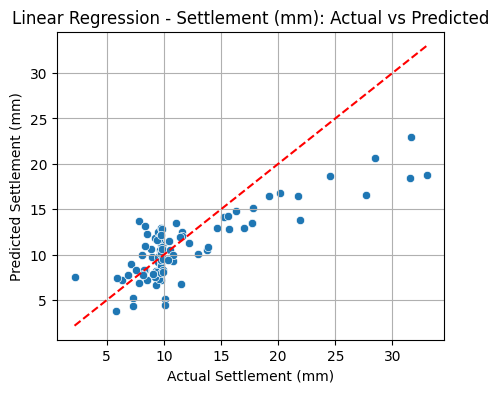


--- Punching Shear Value ---
R² Score: 0.898
Mean Squared Error (MSE): 0.0035
Root Mean Squared Error (RMSE): 0.0588


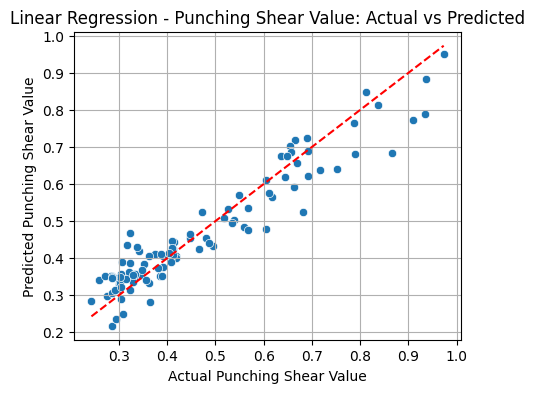


--- Bearing Pressure (kPa) ---
R² Score: 0.782
Mean Squared Error (MSE): 597.0458
Root Mean Squared Error (RMSE): 24.4345


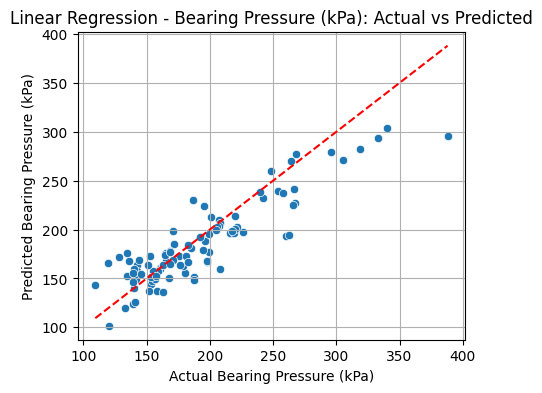


=== Random Forest ===

--- Settlement (mm) ---
R² Score: 0.849
Mean Squared Error (MSE): 4.7012
Root Mean Squared Error (RMSE): 2.1682


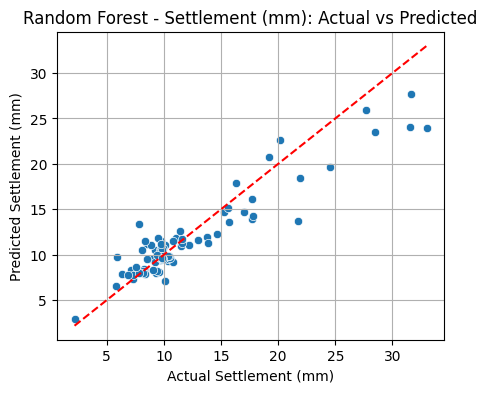


--- Punching Shear Value ---
R² Score: 0.907
Mean Squared Error (MSE): 0.0032
Root Mean Squared Error (RMSE): 0.0562


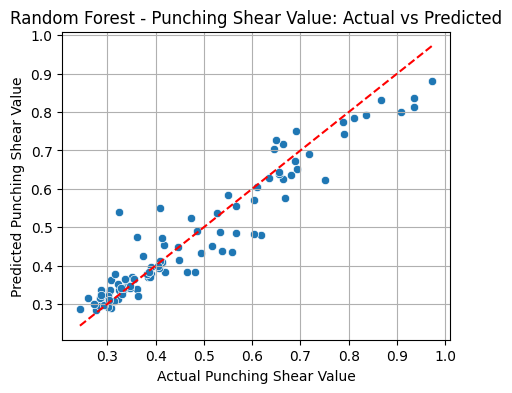


--- Bearing Pressure (kPa) ---
R² Score: 0.875
Mean Squared Error (MSE): 341.8350
Root Mean Squared Error (RMSE): 18.4888


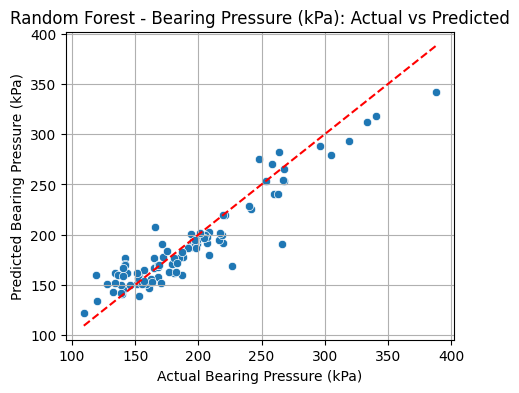


=== XGBoost ===

--- Settlement (mm) ---
R² Score: 0.862
Mean Squared Error (MSE): 4.2981
Root Mean Squared Error (RMSE): 2.0732


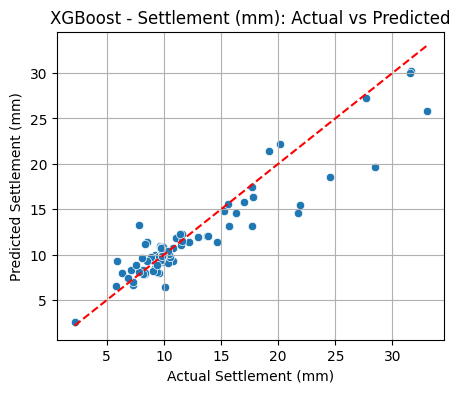


--- Punching Shear Value ---
R² Score: 0.911
Mean Squared Error (MSE): 0.0030
Root Mean Squared Error (RMSE): 0.0549


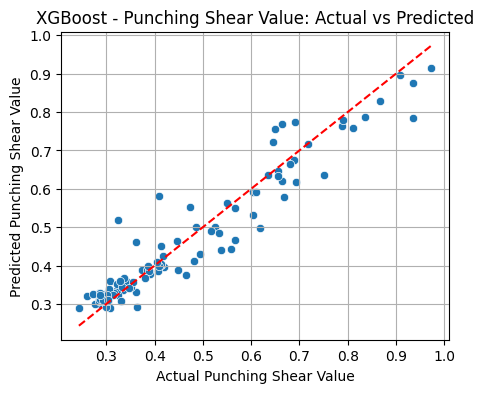


--- Bearing Pressure (kPa) ---
R² Score: 0.873
Mean Squared Error (MSE): 348.1159
Root Mean Squared Error (RMSE): 18.6579


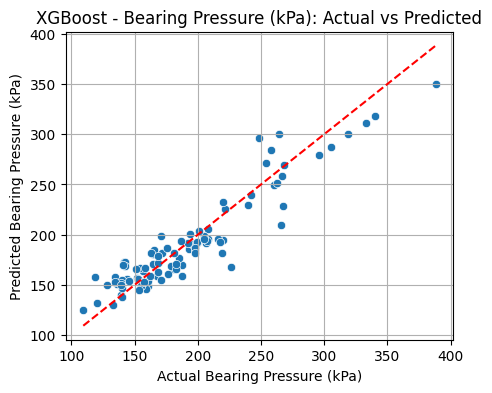


Best Model: XGBoost


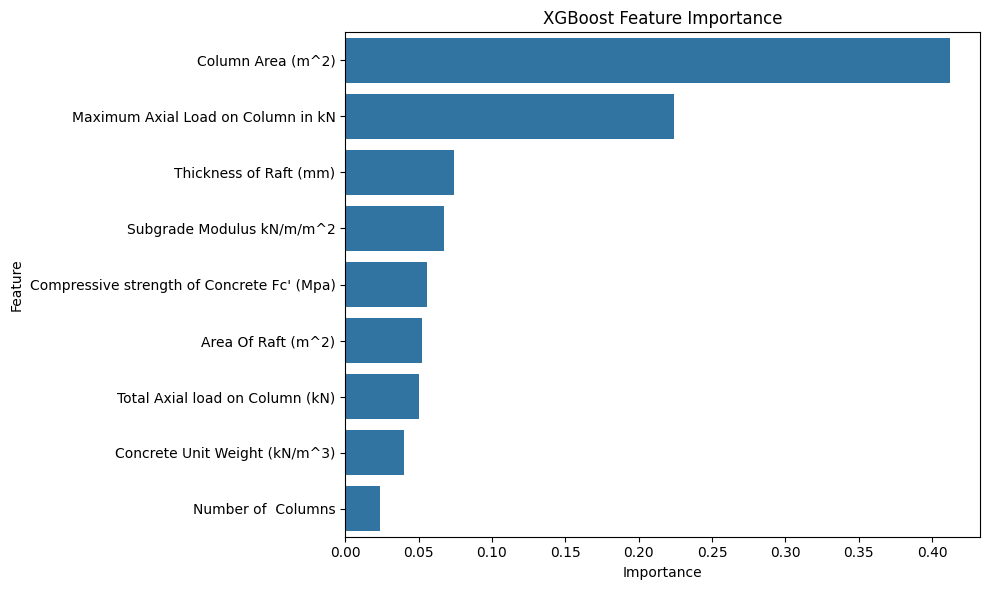


--- Custom Prediction ---
Enter value for 'Number of  Columns': 25
Enter value for 'Area Of Raft (m^2)': 676
Enter value for 'Column Area (m^2)': 0.4356
Enter value for 'Compressive strength of Concrete Fc' (Mpa)': 30
Enter value for 'Concrete Unit Weight (kN/m^3)': 15
Enter value for 'Subgrade Modulus kN/m/m^2': 18000
Enter value for 'Maximum Axial Load on Column in kN': 2000
Enter value for 'Total Axial load on Column (kN)': 30000
Enter value for 'Thickness of Raft (mm)': 800
Settlement (mm): 18.3150
Punching Shear Value: 0.4925
Bearing Pressure (kPa): 128.5076


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Step 0: Upload the Excel file and install dependencies
from google.colab import files
uploaded = files.upload()

!pip install openpyxl scikit-learn xgboost matplotlib seaborn

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Step 2: Load Dataset
data = pd.read_excel('Expanded Analysis of Rafts.xlsx')
data.columns = data.columns.str.strip()  # Clean column names

# Step 3: Define Features and Labels
X = data[['Number of  Columns', 'Area Of Raft (m^2)', 'Column Area (m^2)',
          "Compressive strength of Concrete Fc' (Mpa)", 'Concrete Unit Weight (kN/m^3)',
          'Subgrade Modulus kN/m/m^2', 'Maximum Axial Load on Column in kN',
          'Total Axial load on Column (kN)', 'Thickness of Raft (mm)']]

y = data[['Settlement (mm)', 'Punching Shear Value', 'Bearing Pressure (kPa)']]

# Step 4: Train-Test Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
}

# Step 6: Evaluate Models
best_model = None
best_score = -np.inf

for model_name, base_model in models.items():
    print(f"\n=== {model_name} ===")
    model = MultiOutputRegressor(base_model)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    avg_r2 = 0
    for i, col in enumerate(y.columns):
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        avg_r2 += r2
        print(f"\n--- {col} ---")
        print(f"R² Score: {r2:.3f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Plot actual vs predicted
        plt.figure(figsize=(5, 4))
        sns.scatterplot(x=y_test.iloc[:, i], y=y_pred[:, i])
        plt.xlabel(f"Actual {col}")
        plt.ylabel(f"Predicted {col}")
        plt.title(f"{model_name} - {col}: Actual vs Predicted")
        plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
                 [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'r--')
        plt.grid(True)
        plt.show()

    if avg_r2 > best_score:
        best_score = avg_r2
        best_model = model
        best_model_name = model_name

print(f"\nBest Model: {best_model_name}")

# Step 7: Feature Importance (for tree-based models only)
if best_model_name in ['Random Forest', 'XGBoost']:
    importances = best_model.estimators_[0].feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
    plt.title(f"{best_model_name} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Step 8: Predict with Custom Input
print("\n--- Custom Prediction ---")
user_input = []

for col in X.columns:
    val = float(input(f"Enter value for '{col}': "))
    user_input.append(val)

user_input_scaled = scaler.transform([user_input])
prediction = best_model.predict(user_input_scaled)

for i, col in enumerate(y.columns):
    print(f"{col}: {prediction[0][i]:.4f}")